In [78]:
import numpy as np
import matplotlib.pylab as plt

1. 引入损失函数，找到将损失函数的值最小的参数。
2. 引入函数斜率的梯度法。
3. 实现手写数字识别的学习过程

对于图像识别，机器学习选择从数据中找出规律，使用图像的特征量来学习和识别，但特征量仍是人为设计的。不同的问题需要不同的特征量。而神经网络直接学习图像本身，特征量也由机器学习来，故称**端到端**学习。对所有的问题都可以用同样的流程来识别。  
机器学习的数据分为训练数据和测试数据（监督数据）。最终目标是追求泛化能力，泛化能力是处理为被观察过的数据。

## 损失函数
损失函数是表示神经网络性能的“恶劣程度”的指标。
- 均方误差（mean squared error）
- 交叉熵误差（cross entropy error）

### 均方误差

均方误差公式为 

$\text{E} = \frac{1}{2}\sum_{k}^{}(y_k - t_k)^2$

y_k表示的神经网络的输出，t_k表示监督数据，k表示数据的维数。

In [79]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [80]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
z = mean_squared_error(np.array(y), np.array(t))
print(z)

0.09750000000000003


### 交叉熵误差

$
\text{E} = - \sum_{k}^{} t_k \log(y_k)
$

log 表示以e为底数的自然对数log_e。  
one-hot 表示中 cEE就是正确解标签和对应的输出结果决定。

In [81]:
def cross_entropy_error(y, t):
    y = np.array(y)
    t = np.array(t)
    delta = 1e-7    # 防止 log(0) 出现负无穷
    return -np.sum(t * np.log(y + delta))

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(y, t)


np.float64(0.510825457099338)

## mini-batch 学习
计算损失函数必须将所有的训练数据作为对象。
读入MNIST数据以后，训练数据有60,000个，从中随机抽取10笔，使用 `np.random.choice()`，以此为索引取出mini-batch。

$
\text{CE} = -\frac{1}{N} \sum_{n}^{} \sum_{k}^{} t_nk \log(y_nk)
$

数据有N个，$\text t_{nk}$ 表示数据第n个数据的第k个元素的值。

因为数据集一般训练数据都有很多，一次读入数据将花费较长时间。所以从全部数据中选出一部分，作为全部数据的近似，神经网络的学习从训练数据中选出一批数据称为 mini-batch，小批量。

In [82]:
def cross_entropy_error_minibatch(y, t):
    y = np.array(y)
    t = np.array(t)
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

举例：  
- 当y维度为1时
- 当y不为1时

In [83]:
# 假设 y 是模型输出的概率分布（一维列表或数组）
y = [0.1, 0.7, 0.2]  # 原始输入是列表，维度为 1
t = [0, 1, 0]        # 目标标签（假设是 one-hot 编码）
y = np.array(y)
t = np.array(t)
y.shape

(3,)

In [84]:
Y = y.reshape(1, y.size)
Y

array([[0.1, 0.7, 0.2]])

In [85]:
Y.shape

(1, 3)

In [86]:
Y.shape[0]

1

In [87]:
# 假设 y 是批量为 2 的模型输出（二维数组）
y = [
    [0.2, 0.8],  # 第一个样本的概率分布
    [0.6, 0.4]   # 第二个样本的概率分布
]
t = [
    [0, 1],      # 第一个样本的标签
    [1, 0]       # 第二个样本的标签
]

```python
loss = -np.sum(t * np.log(y + 1e-7)) / batch_size
       = -np.sum([
             [0*log(0.2+1e-7), 1*log(0.8+1e-7)],  # 第一个样本的损失
             [1*log(0.6+1e-7), 0*log(0.4+1e-7)]   # 第二个样本的损失
       ]) / 2
       = -(log(0.8000001) + log(0.6000001)) / 2
       ≈ -(0.2231 + 0.5108) / 2 ≈ 0.3670
```

若非one-hot表示，而是标签形式

In [88]:
def cross_entropy_error_minibatch_label(y, t):
    y = np.array(y)
    t = np.array(t)
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

示例：  
此处用到y的高级引用，分别是y(0, 2), y(1, 0), y(2, 3)

In [89]:
y = np.array([
    [0.1, 0.2, 0.5, 0.1, 0.1],  # 样本1的预测概率
    [0.8, 0.1, 0.0, 0.1, 0.0],  # 样本2
    [0.0, 0.1, 0.3, 0.4, 0.2]   # 样本3
])
t = [2, 0, 3]  # 样本1的真实类别是2，样本2是0，样本3是3

In [90]:
y.shape[0]

3

## 设定损失函数的意义
因为神经网络的学习寻找最优参数时，需要找到让损失函数尽可能小的参数。为实现这一目标需要计算参数的导数（梯度）（即对损失函数求导），以此导数为指引，逐步更新参数的值。  
**若使用识别精度作为指标，则参数的导数在绝大多数地方都会变成0。** 改变参数识别精度的变化不连续，对参数的微小变化不敏感。  
同样**阶跃函数**的导数在绝大多数地方均为0，参数的微小变化也会被其抹杀。
而sigmoid函数的导数在任何地方都不为0，神经网络的学习的以正确进行。

## 数值微分

In [91]:
import numpy as np
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

为了缩小h值，但可能产生舍入误差——省略小数精细部分。python中

In [92]:
np.float32(1e-50)

np.float32(0.0)

可以看到会变成0.0，故应该使用10^-4.

而第二个错误是，“真导数”是函数在x上的斜率，而函数中计算的史(x+h)到x的斜率，h不能真的无限趋于0.

改进方法：使用中心差分。（上述方法为前向差分）

In [93]:
def numerical_diff(f, x):
    h = 1e-4    # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

## 数值微分的例子
$\text{y} = 0.01x^{2} + 0.1x$

$\text{Y} = 0.02x + 0.1$

In [94]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

绘制图像

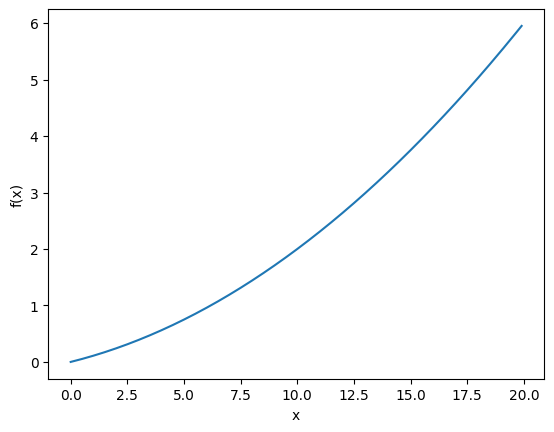

In [95]:
import numpy as np
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

计算其在5和10点的导数

In [96]:
numerical_diff(function_1, 5)

0.1999999999990898

In [97]:
numerical_diff(function_1, 10)

0.2999999999986347

## 偏导数
for
$f\left ( x_{0}, x_{1} \right ) = x_{0}^{2} + x_{1}^{2}$

In [110]:
def function_2(x):
    return x[0]**2 + x[1]**2    # or return np.sum(x**2)

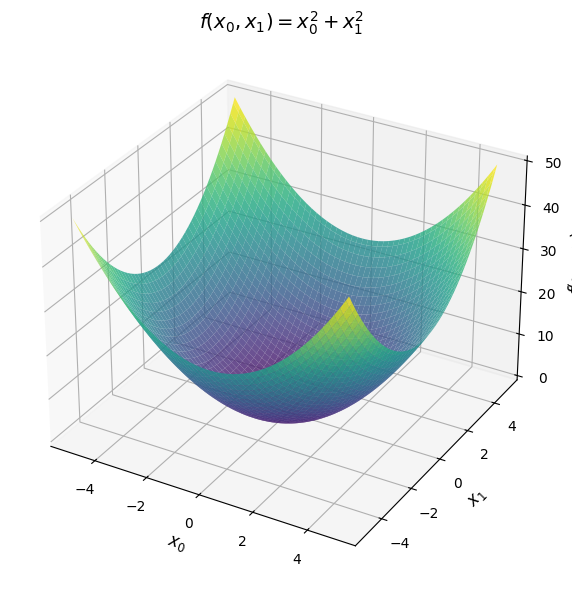

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 定义函数
def f(x0, x1):
    return x0**2 + x1**2

# 生成数据点
x0 = np.linspace(-5, 5, 100)
x1 = np.linspace(-5, 5, 100)
X0, X1 = np.meshgrid(x0, x1)  # 创建网格坐标
Z = f(X0, X1)                 # 计算函数值

# 绘制3D图像
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0, X1, Z, cmap='viridis', alpha=0.8)

# 添加标签
ax.set_xlabel('$x_0$', fontsize=12)
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_zlabel('$f(x_0, x_1)$', fontsize=12)
ax.set_title('$f(x_0, x_1) = x_0^2 + x_1^2$', fontsize=14)

plt.tight_layout()
plt.show()

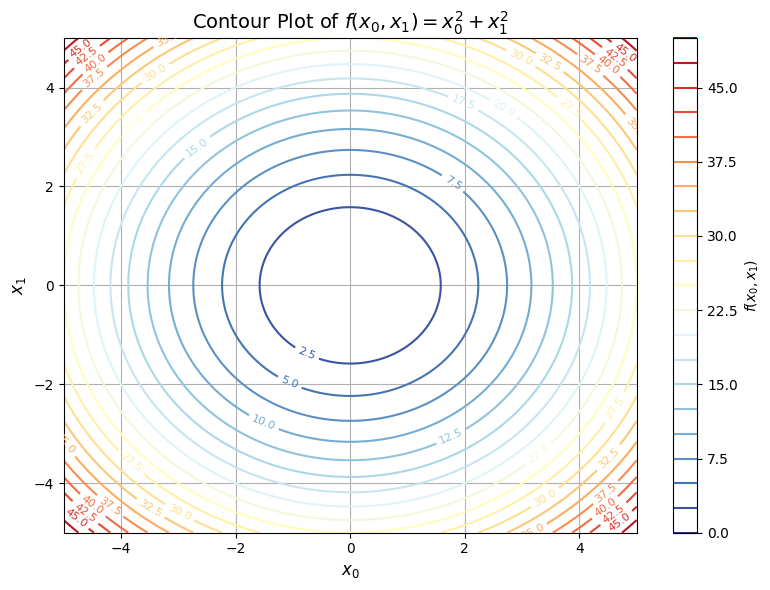

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数和数据
def f(x0, x1):
    return x0**2 + x1**2

x0 = np.linspace(-5, 5, 100)
x1 = np.linspace(-5, 5, 100)
X0, X1 = np.meshgrid(x0, x1)
Z = f(X0, X1)

# 绘制等高线图
plt.figure(figsize=(8, 6))
contour = plt.contour(X0, X1, Z, levels=20, cmap='RdYlBu_r')
plt.clabel(contour, inline=True, fontsize=8)  # 标注等高线值

# 添加标签和标题
plt.xlabel('$x_0$', fontsize=12)
plt.ylabel('$x_1$', fontsize=12)
plt.title('Contour Plot of $f(x_0, x_1) = x_0^2 + x_1^2$', fontsize=14)
plt.colorbar(label='$f(x_0, x_1)$')

plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

例题：

In [100]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [101]:
numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 梯度 gradient

In [ ]:
def numerical_gradient(f, x):
    h = 1e-4    # 0.0001
    grad = np.zeros_like(x) # 生成和x形状相同的数组

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h)的计算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)的计算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad


In [103]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [104]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [105]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

梯度指示的方向是各点处的函数值减小最多的方向

## 梯度法

η 称为**学习率**，决定在一次学习中应该学习多少，以及在多大程度上更新参数。

以上步骤反复执行，逐渐减少函数值。

学习率需要事先确定数值，如0.001等。

In [106]:
def gradient_descent(f, init_x, lr=0.01,step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x

参数f是要进行最优化的函数，init_x是初始值，lr是学习率learning rate，step_num是梯度法的重复次数。

问题：请用梯度法求func2的最小值。

In [107]:
init_x = np.array([-3.0, -4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10, -8.14814391e-10])

初始值设置为(-3.0, -4.0),结果接近(0, 0)。

经测试，学习率设置过大过小都无法得到好的结果。人工设定的参数为**超参数**，区别于神经网络的参数（权重和偏置）。

## 神经网络的梯度
实现一个名为simpleNet的类用以实现梯度的计算


In [108]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)    # 用高斯分布进行初始化
    
    def predic(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predic(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss


ModuleNotFoundError: No module named 'common'

In [ ]:
net = simpleNet()
print(net.W)

[[ 1.44457943  0.56733554  1.30153995]
 [ 0.10133863  0.41570883 -0.13155612]]


In [ ]:
x = np.array([0.6, 0.9])
p = net.predic(x)
print(p)

[0.95795243 0.71453927 0.66252347]


In [ ]:
np.argmax(p) # 索引的最大值

np.int64(0)

In [ ]:
t = np.array([0,0,1]) # 正确解标签
net.loss(x,t)

np.float64(1.222920322804335)

then求梯度

W是个伪参数

In [ ]:
def f(W):
    return net.loss(x, t)

In [ ]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.23732669  0.18605168 -0.42337836]
 [ 0.35599003  0.27907751 -0.63506754]]


py中定义简单的函数，可以用lambda表示法

使用了 Python 的 lambda 匿名函数，它的作用是定义一个简单的函数，而不用正式使用 def 来定义。lambda 是 Python 的关键字，用于创建 匿名函数（即没有名字的函数），通常用于简化代码，特别是在需要短小函数的地方（比如作为参数传递给高阶函数 map、filter 或 sorted）。

```python
lambda 参数: 返回值
```

In [ ]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)